In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/.env


True

In [4]:
%%time

from llm_toolkit.eval_openai import *
from tqdm.notebook import tqdm

tqdm.pandas()

data_path = os.getenv("DATA_PATH")
results_path = "paper/data/ollama_model_results_v3-A6000_metrics.csv"
num_ctx = os.getenv("NUM_CTX")
data_path, results_path, num_ctx

loading env vars from: /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/.env
Adding /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents to sys.path
loading /Users/inflaton/code/engd/papers/maritime-incidents-ai-agents/llm_toolkit/data_utils.py
CPU times: user 2.27 s, sys: 3.05 s, total: 5.32 s
Wall time: 2min 33s


('dataset/GMRID_v3.csv',
 'paper/data/ollama_model_results_v3-A6000_metrics.csv',
 '8192')

In [5]:
import pandas as pd
from llm_toolkit.llm_utils import *
from llm_toolkit.data_utils import *

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   84 non-null     object 
 1   shots                   84 non-null     int64  
 2   eval_time               84 non-null     float64
 3   f1                      84 non-null     float64
 4   accuracy                84 non-null     float64
 5   f1_raw                  84 non-null     float64
 6   accuracy_raw            84 non-null     float64
 7   ratio_valid_categories  84 non-null     float64
 8   total_tokens            84 non-null     int64  
 9   eval_speed              84 non-null     float64
dtypes: float64(7), int64(2), object(1)
memory usage: 6.7+ KB


In [6]:
df2 = pd.read_csv("paper/data/ollama_model_results_v3-RTX4090_metrics.csv")
df3 = pd.read_csv("paper/data/ollama_model_results_v3-M3_Max_metrics.csv")

In [7]:
all_models = df.model.unique().tolist()
all_models

['qwen2.5:0.5b',
 'llama3.2:1b',
 'qwen2.5:1.5b',
 'llama3.2:3b',
 'qwen2.5:3b',
 'qwen2.5:7b',
 'llama3.1:8b',
 'llama3.2-vision:11b',
 'qwen2.5:14b',
 'qwen2.5:32b',
 'llama3.1:70b',
 'llama3.3:70b',
 'qwen2.5:72b',
 'llama3.2-vision:90b']

In [8]:
metrics_df = df[df["model"].isin(all_models)]
metrics_df2 = df2[df2["model"].isin(all_models)]
metrics_df3 = df3[df3["model"].isin(all_models)]

In [9]:
models = all_models
llama_models = [x for x in models if "llama" in x.lower()]
qwen_models = [x for x in models if "qw" in x.lower()]
llama_models, qwen_models

(['llama3.2:1b',
  'llama3.2:3b',
  'llama3.1:8b',
  'llama3.2-vision:11b',
  'llama3.1:70b',
  'llama3.3:70b',
  'llama3.2-vision:90b'],
 ['qwen2.5:0.5b',
  'qwen2.5:1.5b',
  'qwen2.5:3b',
  'qwen2.5:7b',
  'qwen2.5:14b',
  'qwen2.5:32b',
  'qwen2.5:72b'])

In [62]:
# plot metrics from top_metrics_df and top_metrics_df2, using two subplots. each subplot will have 2 bars for each model, one for f1 and one for eval_speed

def plot_metrics_vs_shots_dfs(dfs, platforms):
    fig, axes = plt.subplots(len(dfs), 3, figsize=(12, 3 * len(dfs)))
    # print(axes.shape)
    subplot_id = ord('a')
    for i, metrics_df in enumerate(dfs):
        axs = axes[i]
        plot_metrics_vs_shots(
            metrics_df,
            models[:5],
            markers[:5],
            ["f1"],
            ["F1 Score"],
            ylimits_offset=0.05,
            # log_scales=[True],
            bbox_to_anchor=(0.5, -1),
            ax=axs[0],
            legend=i==len(dfs)-1,
            auto_plt_show=False,
            ax_title=f"({chr(subplot_id)}) {platforms[i]} - Small Models",
        )

        subplot_id += 1

        plot_metrics_vs_shots(
            metrics_df2,
            models[5:10],
            markers[5:10],
            ["f1"],
            ["F1 Score"],
            ylimits_offset=0.0245,
            # log_scales=[True],
            bbox_to_anchor=(0.5, -1),
            ax=axs[1],
            legend=i==len(dfs)-1,
            auto_plt_show=False,
            ax_title=f"({chr(subplot_id)}) {platforms[i]} - Medium Models",
        )

        subplot_id += 1

        plot_metrics_vs_shots(
            metrics_df,
            models[10:],
            markers[10:],
            ["f1"],
            ["F1 Score"],
            # log_scales=[True],
            ylimits_offset=0.004,
            bbox_to_anchor=(0.5, -0.85),
            ax=axs[2],
            legend=i==len(dfs)-1,
            auto_plt_show=False,
            ax_title=f"({chr(subplot_id)}) {platforms[i]} - Large Models",
        )   

        subplot_id += 1

    plt.tight_layout()

    # reduce space between subplots
    # plt.subplots_adjust(hspace=0.07)

    plt.show()


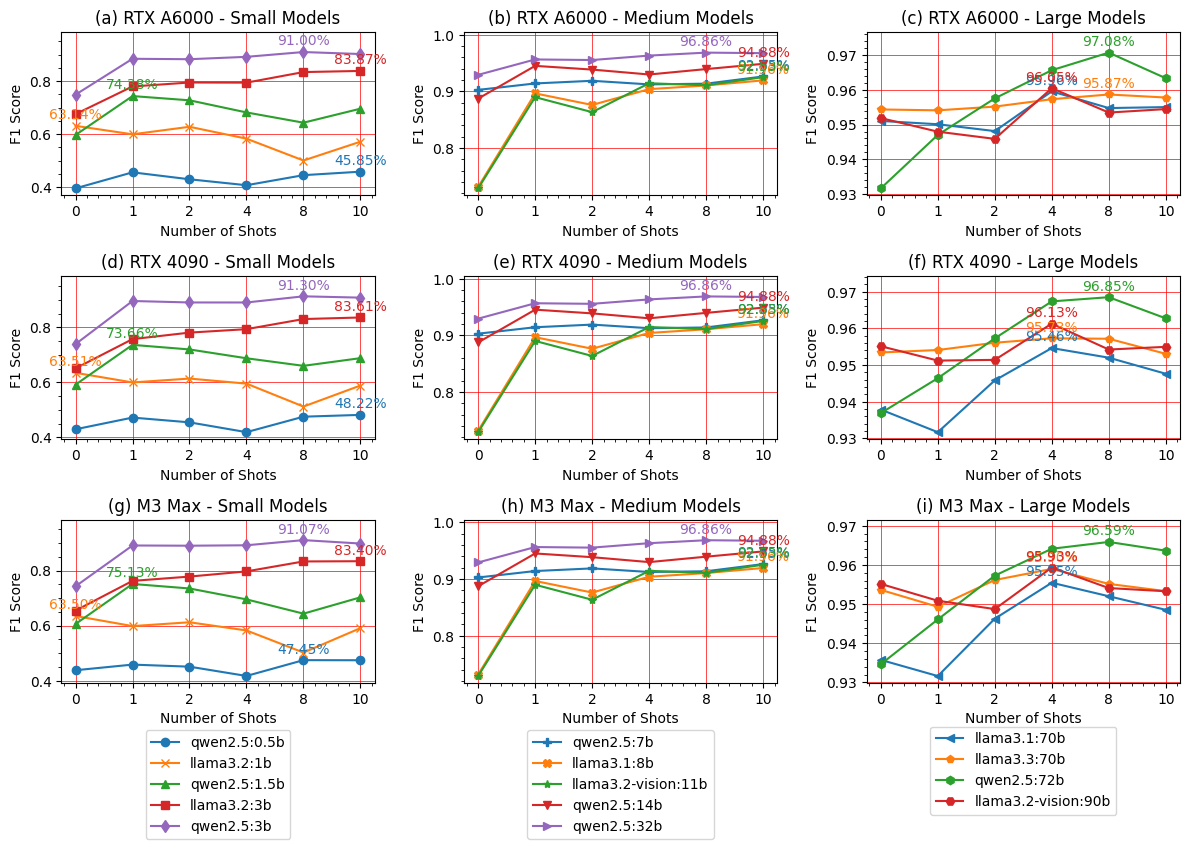

In [63]:
plot_metrics_vs_shots_dfs([metrics_df, metrics_df2, metrics_df3], ["RTX A6000", "RTX 4090", "M3 Max"])